In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from warnings import filterwarnings
filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

## Loading The Image

In [2]:
path = "Images/test_image.jpg"
image = cv2.imread(path)

In [3]:
def display(image):
    
    plt.figure(figsize = (15,5))
    plt.imshow(image, cmap = "gray")
    plt.title(f"Shape : {image.shape}")
    plt.show()

In [4]:
def count_pixels(image):
    
    plt.figure(figsize = (40,10))
    sns.countplot(pd.Series(image.ravel()))
    plt.title("Pixels Counts",fontsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

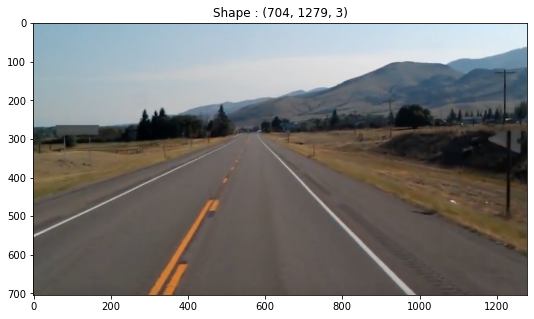

In [5]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

display(image)

## Convert Gray

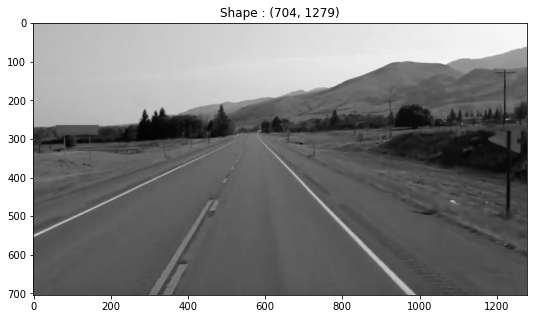

In [6]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

display(gray_image)

In [7]:
gray_image.max(),gray_image.min(),image.max(),image.min()

(246, 0, 254, 0)

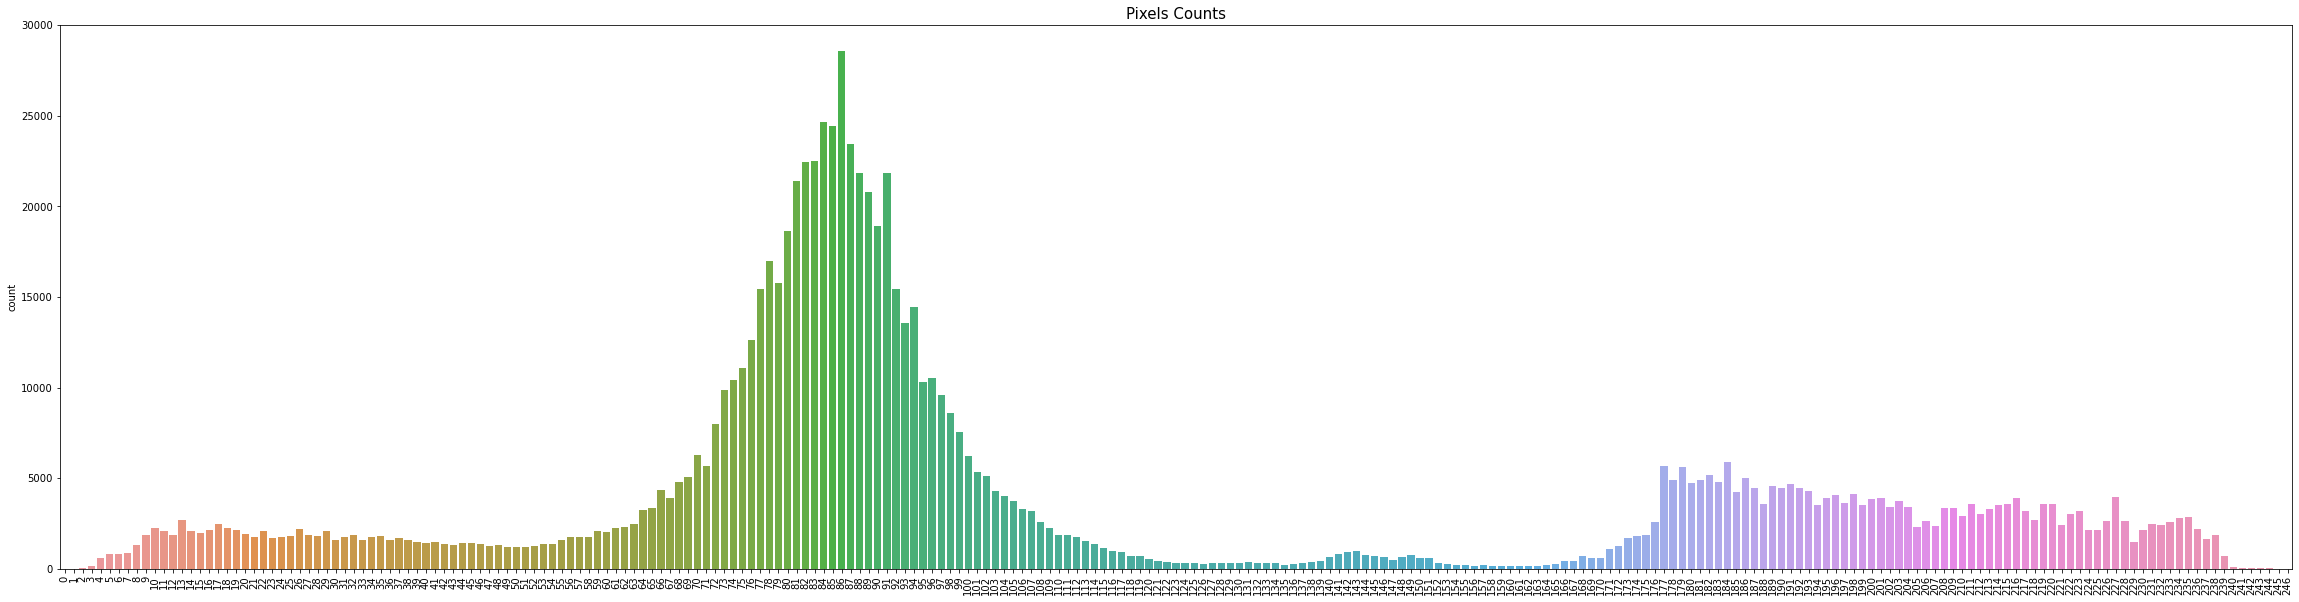

In [8]:
count_pixels(gray_image)

## Smoothening Image

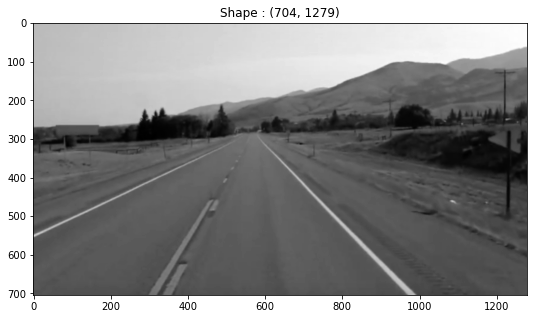

In [9]:
blur_image = cv2.GaussianBlur(gray_image, ksize = (5,5), sigmaX = 0)
display(blur_image)

In [10]:
# Gray ile Blur arasındaki max min farka bak !!!

blur_image.max(),blur_image.min(),gray_image.max(),gray_image.min(),image.max(),image.min()

(241, 3, 246, 0, 254, 0)

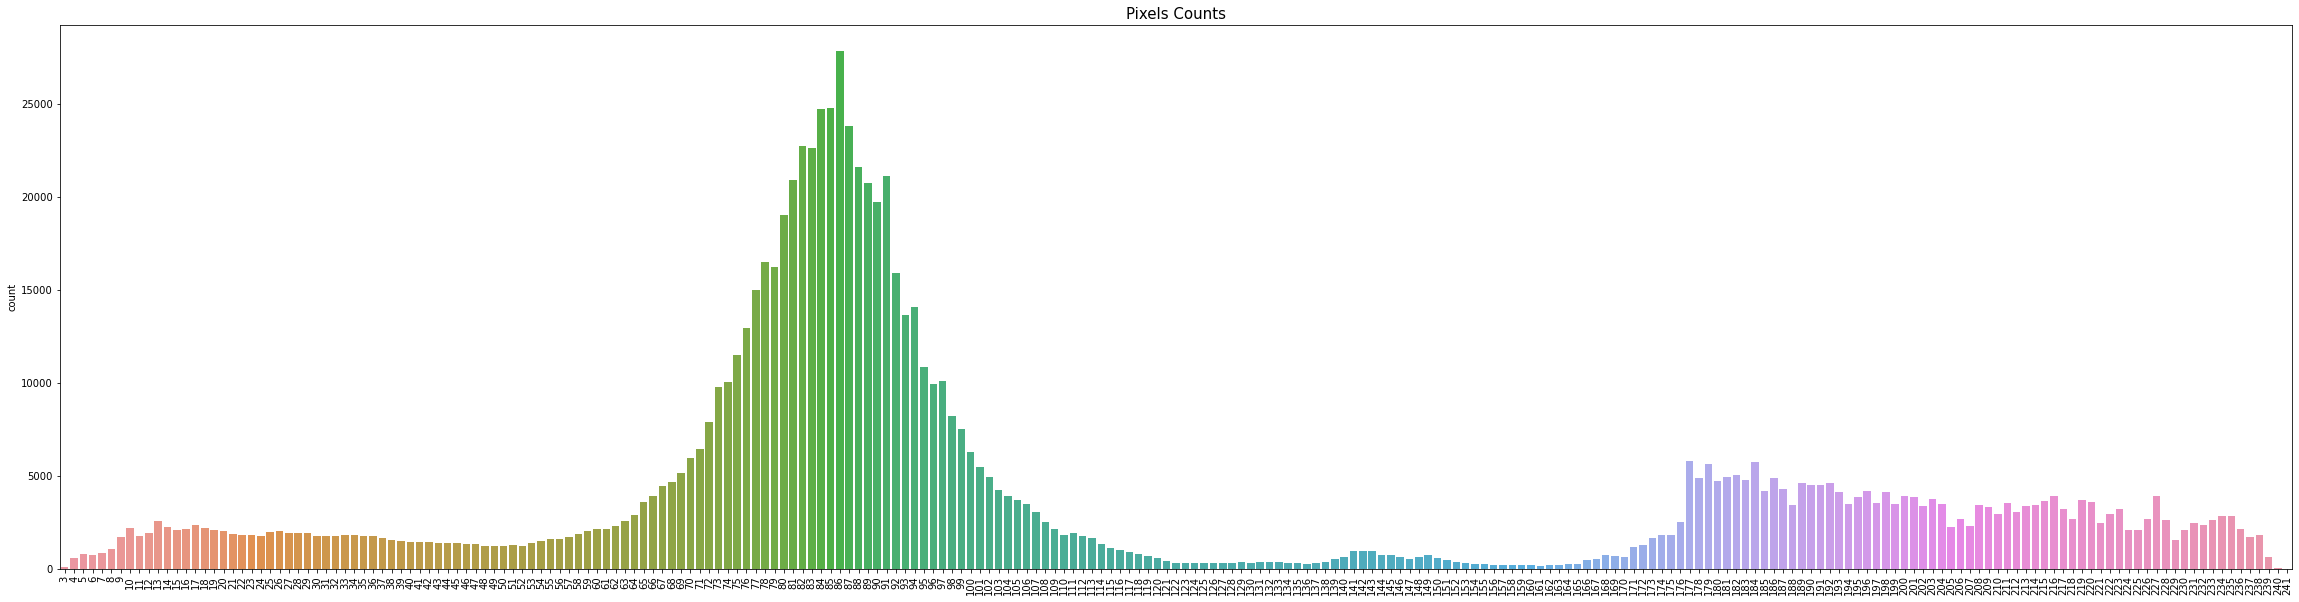

In [11]:
# Grafik te bazı değerlerin azaldığını görüyoruz !!!

count_pixels(blur_image)

## Simple Edge Detection

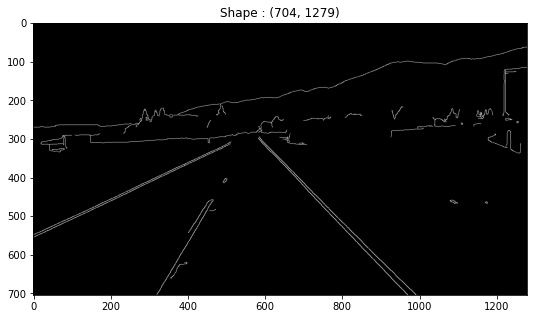

In [12]:
canny_image = cv2.Canny(blur_image, 50, 150)
display(canny_image)

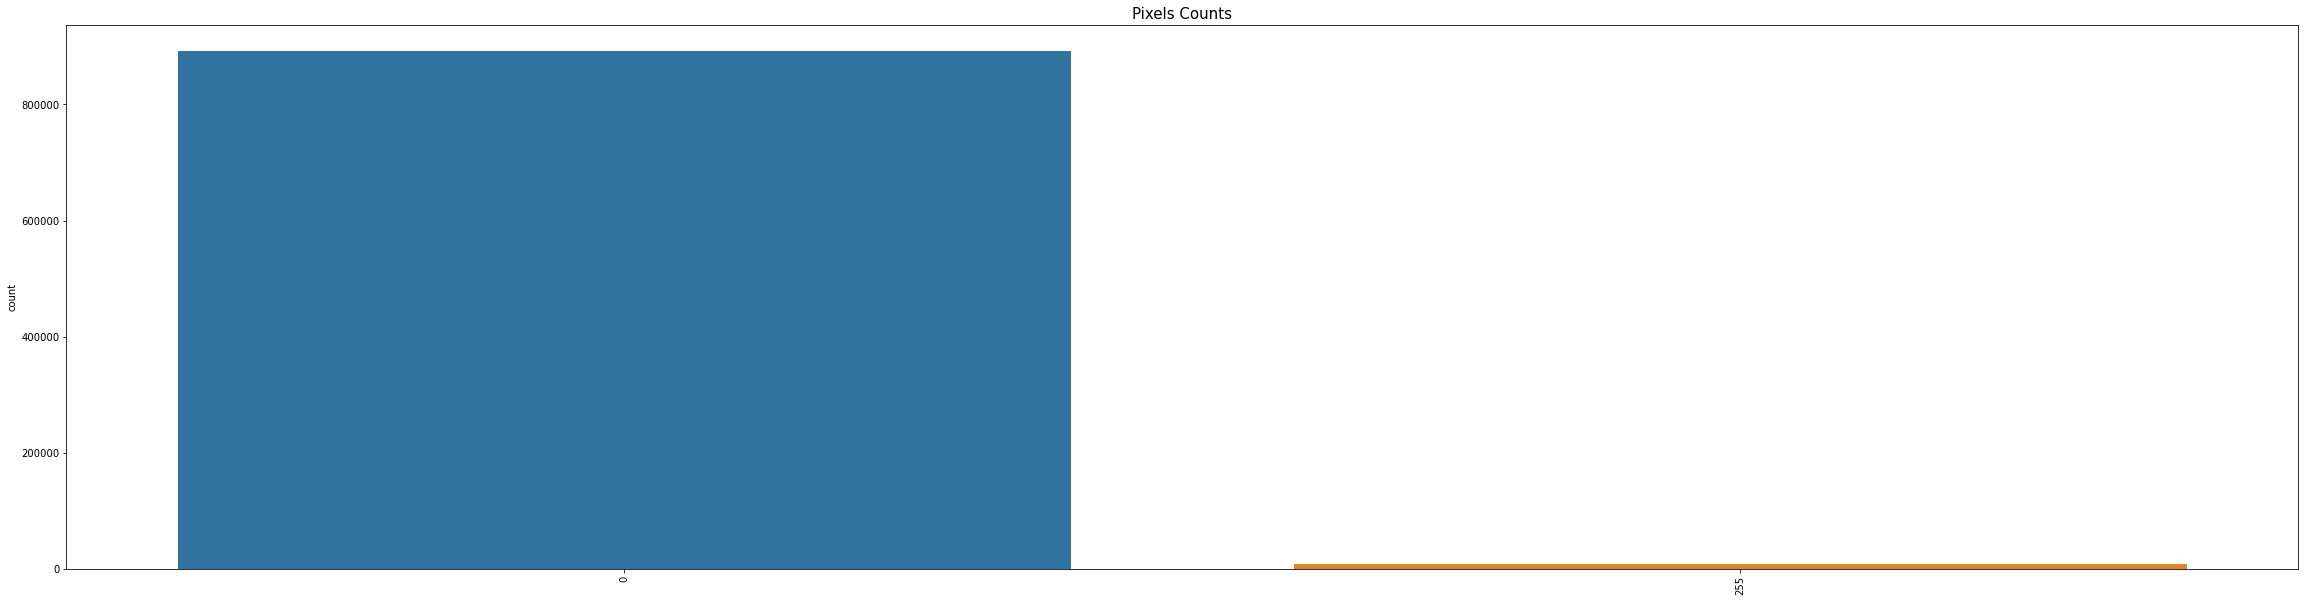

In [13]:
count_pixels(canny_image)

## Region Of Interest (ROI)

In [14]:
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Şunu bir kaldır bakalım öyle dene sonra !!!

def canny_conv(image):
    
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur_img = cv2.GaussianBlur(gray_img, ksize = (5,5), sigmaX= 0)
    canny_img = cv2.Canny(blur_img, 50,150)
    return canny_img

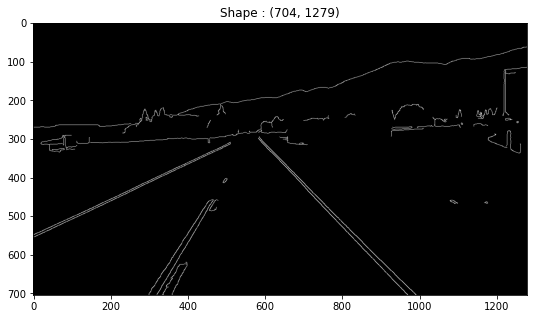

In [15]:
canny = canny_conv(image)
display(canny)

In [16]:
def region_of_interest(image):
    
    height = image.shape[0]
    triangle = np.array([[(200,height), (1100, height), (550,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, triangle,(255,255,255))
    
    return mask

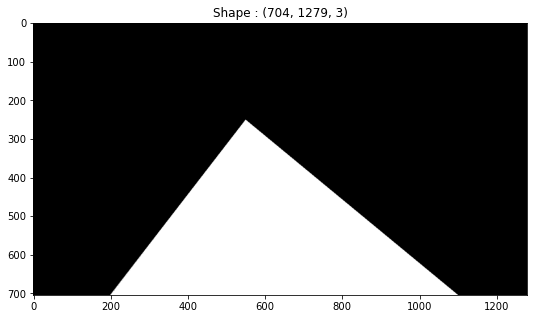

In [17]:
roi = region_of_interest(image)
display(roi)

## Bitwise_And

In [18]:
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([[(200,height), (1100, height), (550,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask,triangle,(255,255,255))
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

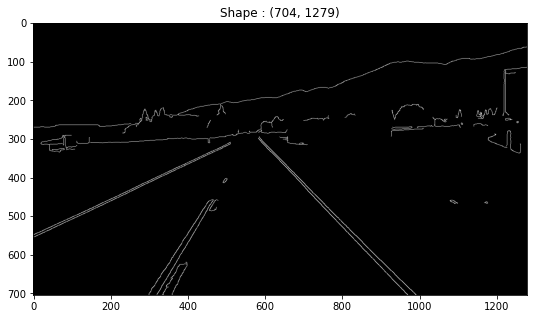

In [19]:
# Mask Çıktısına bak !!! (roi)
# Dağlık alanlarda yani yukardaki kısımlarda mask değeri 0 olduğu için her türlü yutucak
# Ama yolu belirlenmiş olduğumuz üçgende orası ne gelirse gelsin aynı o bölge olarak kalıcak
# Ne geliyorsa canny değerinde beyaz üçgen kısmı öyle kalıcak

# Üçgen içindeki değerlerden bir örnek olsun
# Örnek1 : 1111 Bu mask
# Örnek2 : 1100 Bu canny
# Sonuç  : 1100 Burda görüyoruz ki canny neyse o çıkıyor bu beyaz yani 1111 mask için 

# mask : 0000 - Canny : 1100 >> result : 0000 Buda siyah olan kısımlar için !!!

canny = canny_conv(image)

display(canny)

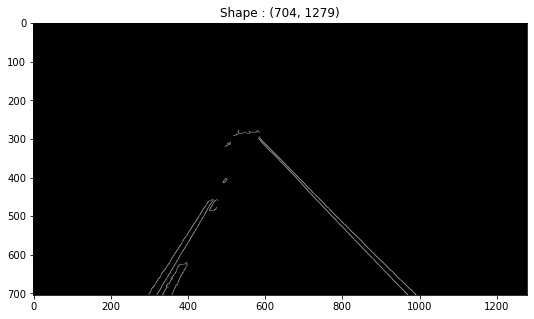

In [20]:
cropped_image = region_of_interest(canny)
display(cropped_image)

## Hough_Transform - Line_Detection

In [21]:
np.pi / 180

0.017453292519943295

In [22]:
lines = cv2.HoughLinesP(image= cropped_image, rho = 2, theta = np.pi / 180, threshold = 100, lines = np.array([]),
                       minLineLength = 40 , maxLineGap = 5)

In [23]:
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            #print(line)
            line = line.reshape(4)
            #print(line)
            x1,y1,x2,y2 = line
            cv2.line(line_image, (x1,y1),(x2,y2),(0,0,255),10)
    
    return line_image

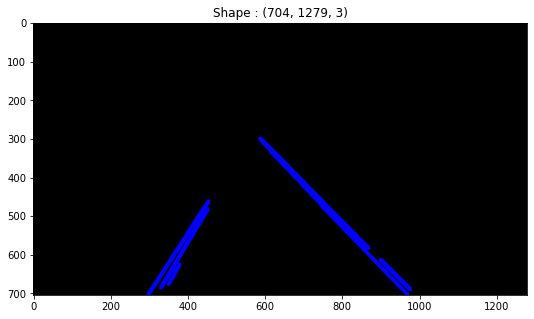

In [24]:
lines_image = display_lines(image, lines)
display(lines_image)

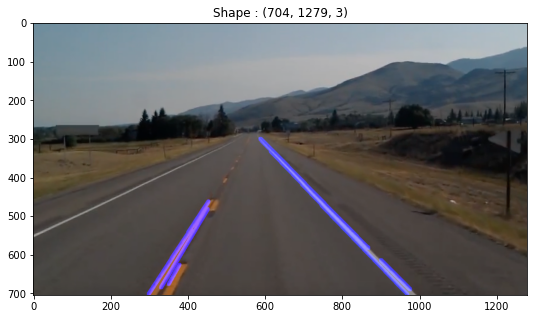

In [25]:
combo_image = cv2.addWeighted(image,0.8,lines_image,1,1)
display(combo_image)

## Optimizing

In [26]:
deneme = [(1.000000000000002, -287.00000000000153), (1.0392156862745074, -306.2941176470568)]
deneme = np.array(deneme)

np.average(deneme, axis = 1)

array([-143.        , -152.62745098])

In [27]:
(1.000000000000002 +  -287.00000000000153) / 2

-143.00000000000077

In [28]:
np.average(deneme, axis = 0)

array([   1.01960784, -296.64705882])

In [29]:
(1.000000000000002 + 1.0392156862745074) / 2

1.0196078431372548

In [30]:
# Burda şimdi y ekseni aşağı doğru giderken artarken
# Yukarı doğru çıkarken azalıyor
# Bildiğimiz slope hesaplama yanı fakat
# Left_Fit Azalıyorken
# Right_Fit Artıyor!! 
# Ayrıma dikkat et !!!

def average_slope_intercept(image, lines):
    
    left_fit = []
    right_fit = []
    
    if lines is None:
        return None
    
    for line in lines :
        
        #print(line)
        line = line.reshape(4)
        #print(line)
        x1,y1,x2,y2 = line
        parameters =np.polyfit((x1,x2),(y1,y2),1)
        #print(parameters)
        slope = parameters[0]
        intercept = parameters[1]
        
        if slope < 0:
            
            left_fit.append((slope,intercept))
        else:
            
            right_fit.append((slope,intercept))
            
    #print(right_fit)
    #print()
    #print(left_fit)
    
    if len(left_fit) and len(right_fit):
            
        # Burda sağ ve soldaki değerlerin ortalama slope ile interceptm yakalıyoruz !!!
        
        left_fit_average = np.average(left_fit, axis = 0)
        right_fit_average = np.average(right_fit,axis = 0)
        #print(left_fit_average)
        #print(right_fit_average)
        
        left_line = make_coordinates(image, left_fit_average)
        right_line = make_coordinates(image, right_fit_average)
        
        return np.array([left_line,right_line])
        
def make_coordinates(image, line_parameters):
    
    slope, intercept = line_parameters
    #print(image.shape)
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    
    return np.array([x1,y1,x2,y2])


average_slope_intercept(image, lines)

array([[309, 704, 484, 422],
       [985, 704, 705, 422]])

In [31]:
averaged_lines = average_slope_intercept(image,lines)
averaged_lines

array([[309, 704, 484, 422],
       [985, 704, 705, 422]])

In [32]:
#display(lines_image)

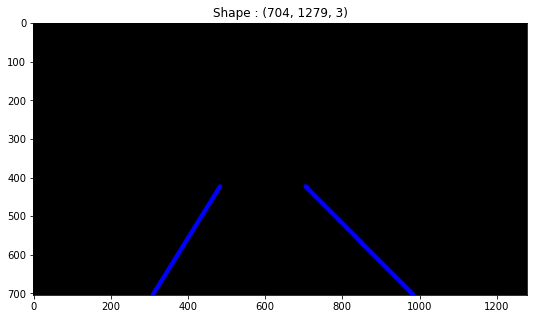

In [33]:
last_lines_image = display_lines(image, averaged_lines)
display(last_lines_image)

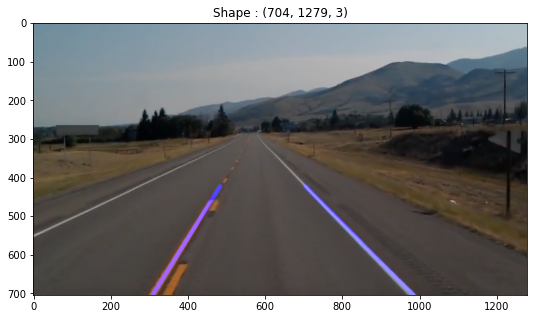

In [34]:
last_combo_image = cv2.addWeighted(image, 0.8, last_lines_image,1,1)
display(last_combo_image)

## Summary

In [35]:
# Step 1 :
path = "Images/test_image.jpg"
image = cv2.imread(path)

def canny_conv(image):
    
    gray_img = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_img , ksize = (5,5), sigmaX = 0)
    canny_img = cv2.Canny(blur_img,50,150)
    
    return canny_img

canny = canny_conv(image)

# Step 2:

def region_of_interest(image):
    
    """
    Canny Image Use
    """
    
    height = image.shape[0]
    triangle = np.array([[(200,height), (1100, height), (550,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, triangle,(255,255,255))
    masked_image = cv2.bitwise_and(image, mask )
    
    return masked_image

cropped_image = region_of_interest(canny)

# Step 3: 

# Dikkat canny kullanarak "lines" çizildi dikkat !!!

lines = cv2.HoughLinesP(cropped_image, rho = 2, theta = np.pi / 180, threshold = 100, lines = np.array([]),
                        minLineLength = 40 , maxLineGap = 5)

def display_lines(image,lines):
    
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
        
            line = line.reshape(4)
            x1,y1,x2,y2 = line
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            
    return line_image

#lines_image = display_lines(image, lines)

#combo_image = cv2.addWeighted(image, 0.8, lines_image , 1, 1)

# Step 4:

def average_slope_intercept(image, lines):
    
    left_fit = []
    right_fit = []
    if lines is None:
        return None
    
    for line in lines:
        
        x1,y1,x2,y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2),(y1,y2),1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
            
        else:
            
            right_fit.append((slope,intercept))
            
    if len(left_fit) and len(right_fit):
        
        left_fit_average = np.average(left_fit,axis = 0)
        right_fit_average = np.average(right_fit,axis = 0)
        
        left_line = make_coordinates(image, left_fit_average)
        right_line = make_coordinates(image, right_fit_average)
        return np.array([left_line,right_line])
    
def make_coordinates(image,line_parameters):
    
    slope , intercept = line_parameters
    
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    
    x1 = int((y1-intercept) / slope)
    x2 = int((y2-intercept) / slope)
    
    return np.array([x1,y1,x2,y2])

# Step 5:

averaged_lines = average_slope_intercept(image, lines)
last_line_image = display_lines(image, averaged_lines)
last_combo_image = cv2.addWeighted(image, 0.8, last_line_image,1,1)

In [36]:
averaged_lines

array([[309, 704, 484, 422],
       [985, 704, 705, 422]])

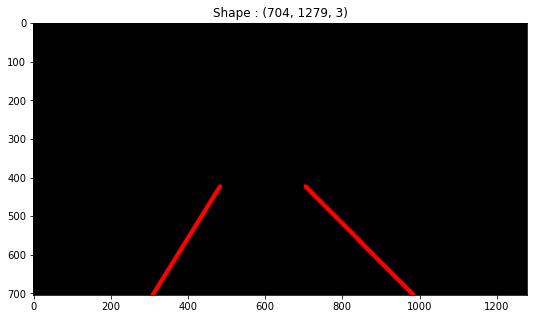

In [37]:
display(last_line_image)

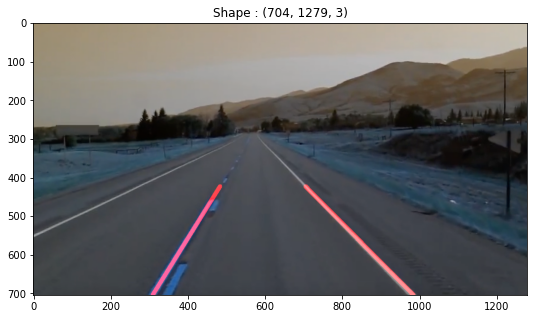

In [38]:
display(last_combo_image)

## Finding Lanes On Video

In [39]:
video_path = "Images/test2.mp4"
cap = cv2.VideoCapture(video_path)

while (cap.isOpened()):
    
    conn, frame = cap.read()
    
    if conn:
        
        canny_image = canny_conv(frame)
        cropped_image = region_of_interest(canny_image)
        lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180,100,
                               np.array([]),40,5)
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = display_lines(frame,averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8,line_image,1,1)
        cv2.imshow("Result", combo_image)
        if cv2.waitKey(1) & 0xFF==ord("q"):
            break
            
    else:
        break

cap.release()
cv2.destroyAllWindows()